In [2]:
from transformers import pipeline
from PIL import Image
import requests

# load pipe
pipe = pipeline(task="depth-estimation", model="LiheYoung/depth-anything-small-hf")

# load image
image = Image.open("assets/fence.jpg")

# inference
depth = pipe(image)["depth"]



Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


FileNotFoundError: [Errno 2] No such file or directory: 'assets/fence.jpg'

In [2]:
depth = pipe(image)["depth"]

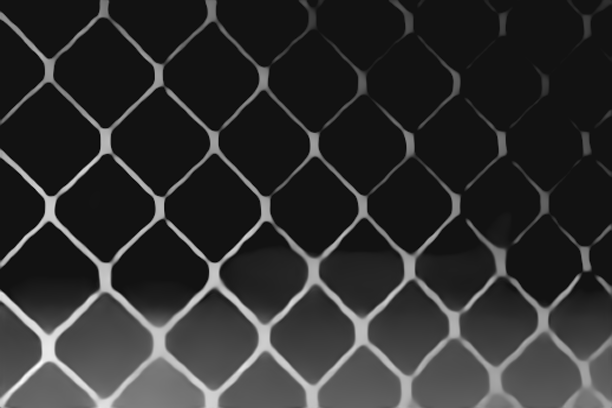

In [4]:
depth

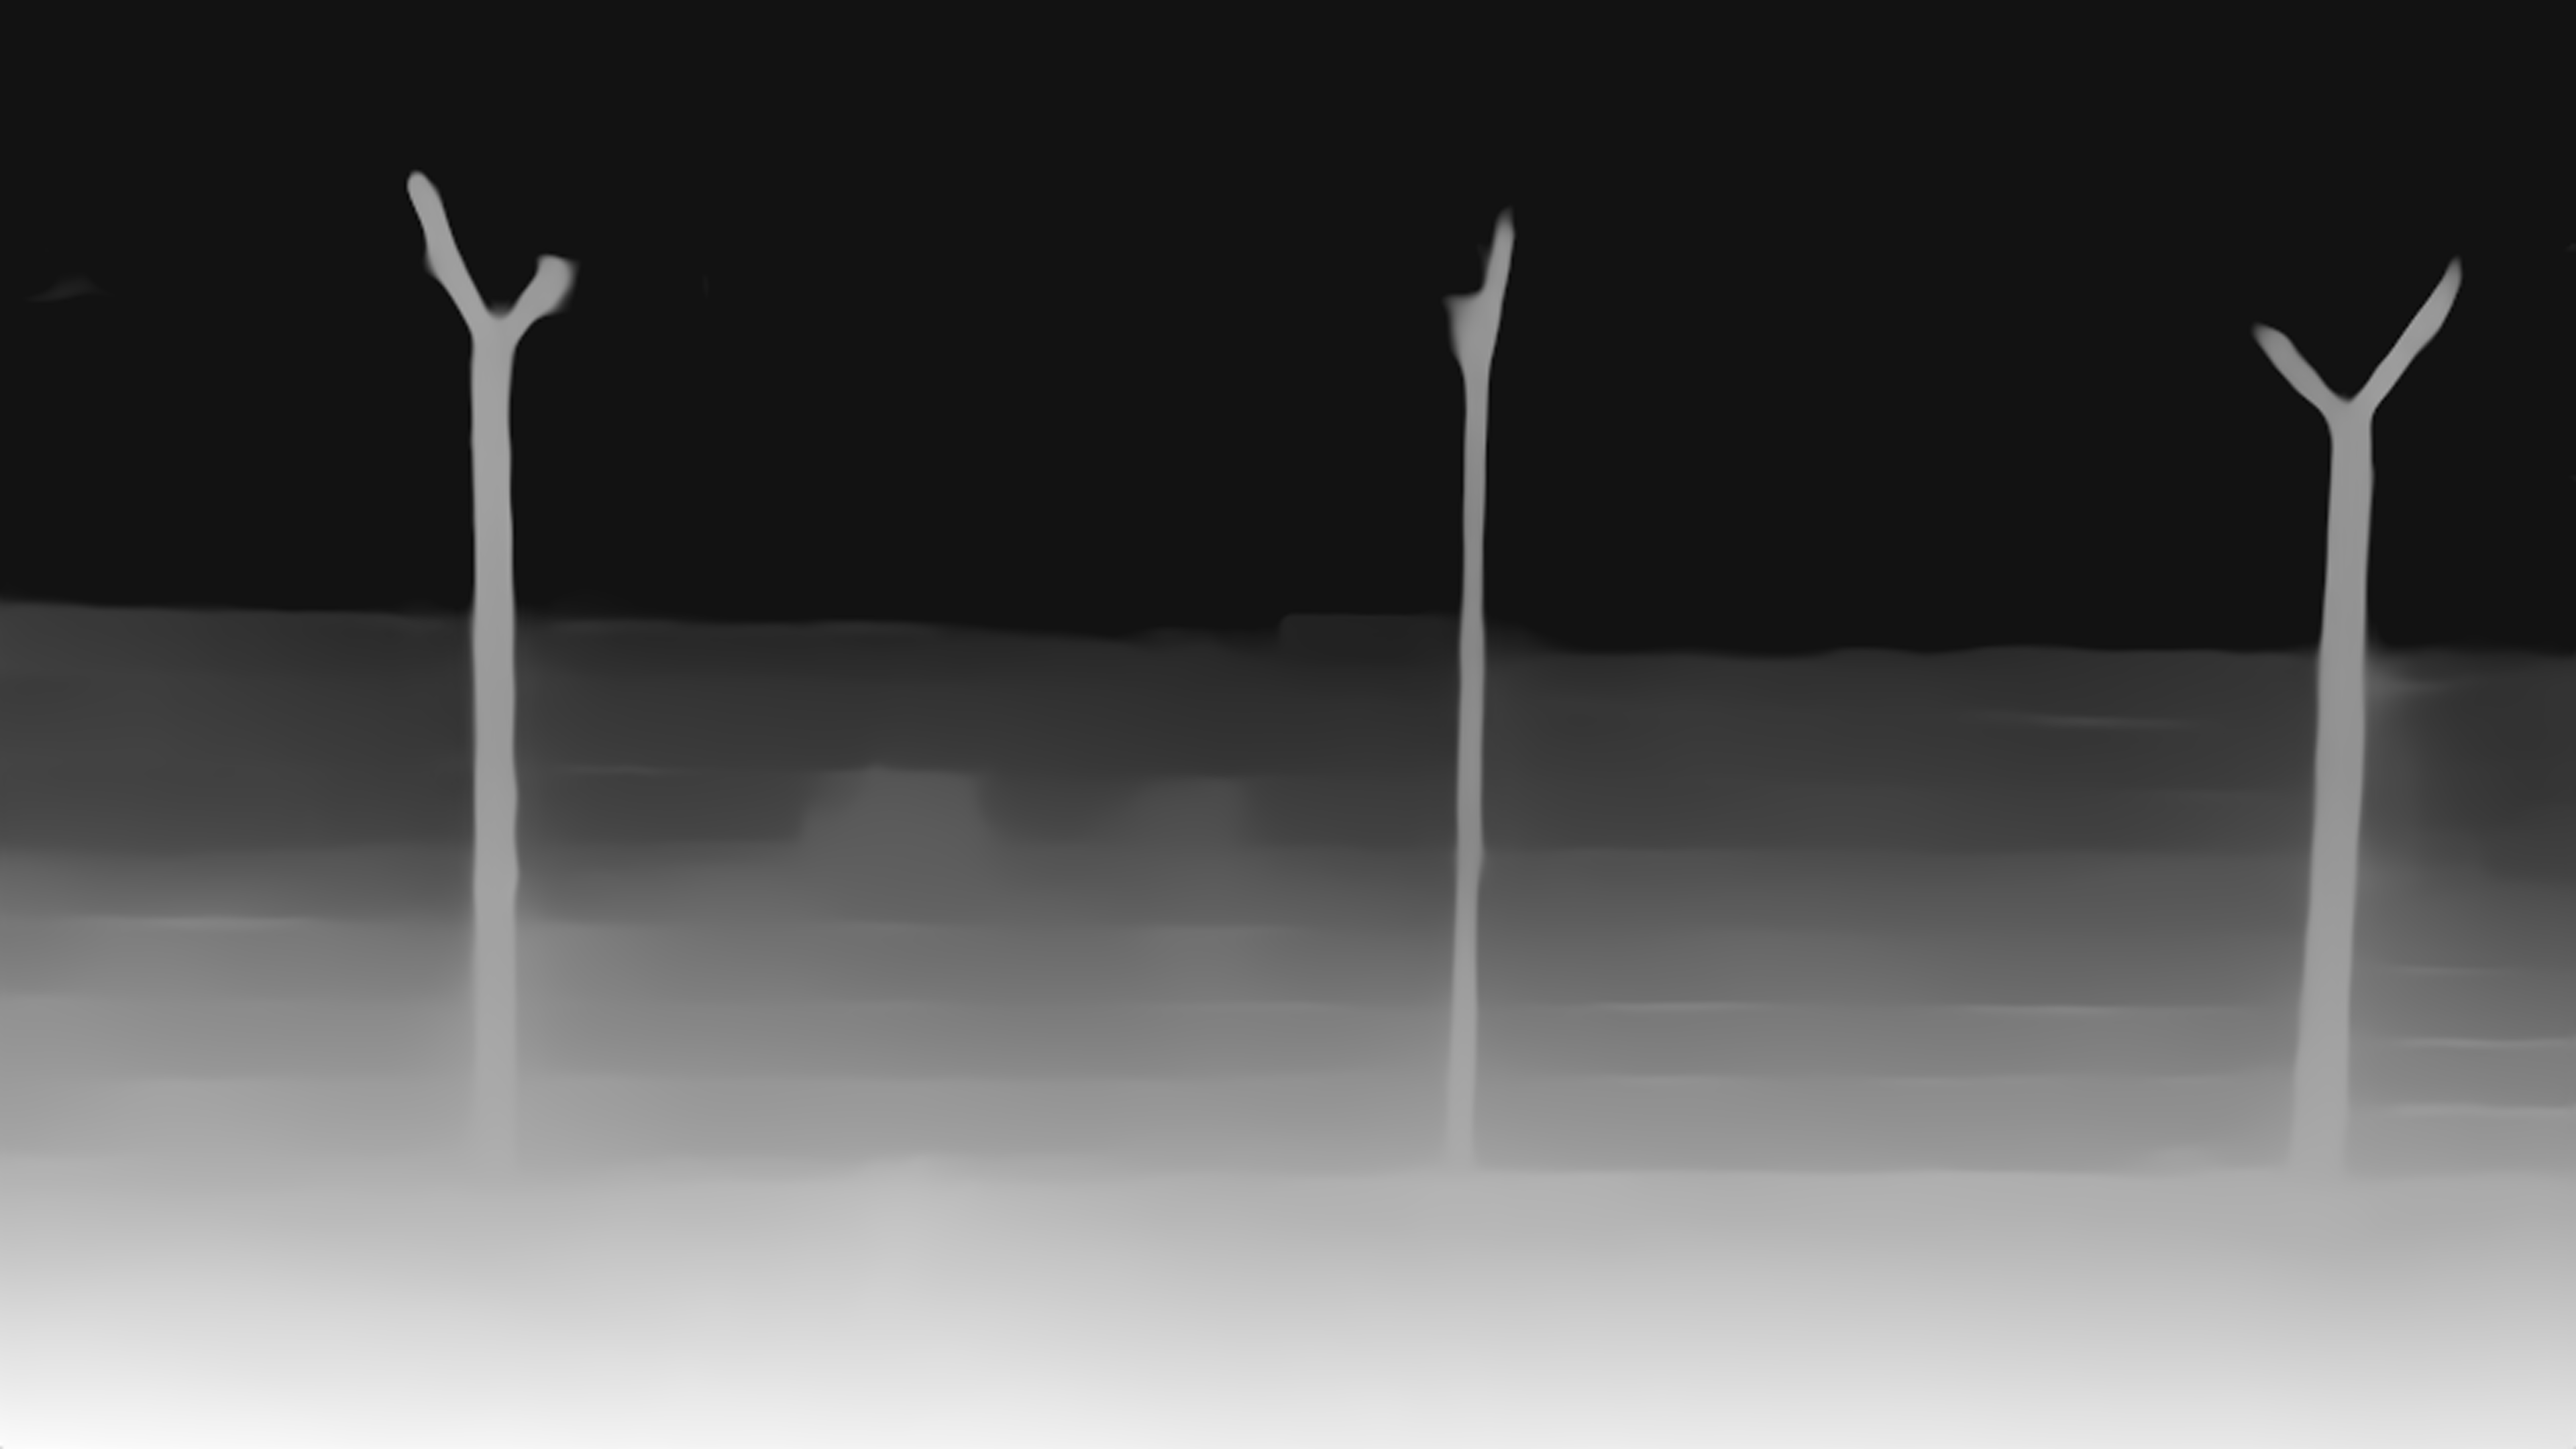

In [5]:
img2 = Image.open('real/real.jpg')

depth2 = pipe(img2)["depth"]

depth2

In [1]:
from pathlib import Path

dataset = Path("kp_dataset")

# for img in dataset.glob("*.jpg"):
#     print(img)
#     depth = pipe(str(img))["depth"]
#     depth.save(f"{dataset}/{img.stem}.depth.bmp")

In [2]:
from PIL import Image
import numpy as np
import cv2 as cv

In [3]:
for img in dataset.glob("*.jpg"):
    depth = cv.imread(f"{dataset}/{img.stem}.depth.bmp")
    mask = cv.imread(f"{dataset}/{img.stem}.bmp")

    depth[mask > 0] = 150
    cv.imwrite(f"{dataset}/{img.stem}.depth.train.bmp", depth)

# Train depth model

In [22]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image

class CustomDepthDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.images_dir = os.path.join(root_dir, 'images')
        self.depths_dir = os.path.join(root_dir, 'depths')
        
        self.image_files = [f for f in os.listdir(self.images_dir) if f.endswith('.jpg')]
        
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        depth_name = img_name.replace('.jpg', '.depth.train.bmp')
        
        image_path = os.path.join(self.images_dir, img_name)
        depth_path = os.path.join(self.depths_dir, depth_name)
        
        image = Image.open(image_path).convert('RGB')
        depth = Image.open(depth_path).convert('L')
        
        image = self.transform(image)
        depth = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])(depth)
        
        return image, depth

class DepthEstimationModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Use ResNet18 as backbone
        backbone = models.resnet18(pretrained=True)
        
        # Remove final fully connected layer
        self.features = nn.Sequential(*list(backbone.children())[:-2])
        
        # Custom depth decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        features = self.features(x)
        depth = self.decoder(features)
        return depth

def finetune_depth_model(dataset_path, epochs=10, batch_size=8):
    # Prepare dataset
    dataset = CustomDepthDataset(dataset_path)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model
    model = DepthEstimationModel()
    
    # Prepare for training
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    # Loss function
    criterion = nn.MSELoss()
    
    # Training loop
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, depths in dataloader:
            images, depths = images.to(device), depths.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            
            # Compute loss
            loss = criterion(outputs, depths)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f'Epoch {epoch+1}, Loss: {total_loss/len(dataloader)}')
    
    # Save model
    torch.save(model.state_dict(), './finetuned_depth_model.pth')
    
    return model

# Usage
if __name__ == '__main__':
    dataset_path = './depth_dataset'
    finetuned_model = finetune_depth_model(dataset_path)

c:\Users\jkoro\Desktop\Studia\ASOL\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jkoro\Desktop\Studia\ASOL\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\jkoro\Desktop\Studia\ASOL\.venv\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([2, 1, 224, 224])) that is different to the input size (torch.Size([2, 1, 112, 112])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_

RuntimeError: The size of tensor a (112) must match the size of tensor b (224) at non-singleton dimension 3

In [3]:
from transformers import AutoModelForDepthEstimation, AutoImageProcessor
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from pathlib import Path

# Ścieżki do danych
image_dir = Path("depth_dataset/images")
depth_dir = Path("depth_dataset/depths")

# model_path = "LiheYoung/depth-anything-small-hf"
model_path = "models/depth_model_v2"

# Ładowanie procesora
processor = AutoImageProcessor.from_pretrained(model_path)

# Przygotowanie datasetu
class DepthDataset(Dataset):
    def __init__(self, image_dir, depth_dir, processor):
        self.image_dir = image_dir
        self.depth_dir = depth_dir
        self.processor = processor
        self.image_files = sorted(image_dir.glob("*"))
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        depth_path = depth_dir / f"{image_path.stem}.depth.train.bmp"
        
        # Wczytanie obrazu i głębi
        image = Image.open(image_path).convert("RGB")
        depth = Image.open(depth_path).convert("L")
        
        # Przetwarzanie obrazu przez procesor
        inputs = self.processor(images=image, return_tensors="pt")
        pixel_values = inputs["pixel_values"].squeeze(0)
        
        # Przetwarzanie głębi do rozmiaru 924
        depth = depth.resize((924, 518))  # Dopasowanie do rozmiaru modelu
        depth = transforms.ToTensor()(depth)
        
        return {
            "pixel_values": pixel_values,
            "labels": depth
        }

# Tworzenie datasetu i DataLoader
dataset = DepthDataset(image_dir, depth_dir, processor)
train_loader = DataLoader(dataset, batch_size=1, shuffle=True)

# Ładowanie modelu
model = AutoModelForDepthEstimation.from_pretrained(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Konfiguracja treningu
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
num_epochs = 100

# Pętla treningowa
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs} started...")
    model.train()
    total_loss = 0
    
    for batch in train_loader:
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(pixel_values=pixel_values)
        predicted_depth = outputs.predicted_depth
        
        # Dopasowanie kształtu wyjścia (jeśli potrzebne)
        if predicted_depth.ndim == 3:
            predicted_depth = predicted_depth.unsqueeze(1)
            
        # Obliczanie straty
        loss = torch.nn.functional.mse_loss(predicted_depth, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

print("Trening zakończony!")

Epoch 1/100 started...
Epoch 1/100, Loss: 4.1790
Epoch 2/100 started...
Epoch 2/100, Loss: 0.4839
Epoch 3/100 started...
Epoch 3/100, Loss: 0.0662
Epoch 4/100 started...
Epoch 4/100, Loss: 0.1405
Epoch 5/100 started...
Epoch 5/100, Loss: 0.1256
Epoch 6/100 started...
Epoch 6/100, Loss: 0.1353
Epoch 7/100 started...
Epoch 7/100, Loss: 0.1176
Epoch 8/100 started...
Epoch 8/100, Loss: 0.1045
Epoch 9/100 started...
Epoch 9/100, Loss: 0.1007
Epoch 10/100 started...
Epoch 10/100, Loss: 0.0843
Epoch 11/100 started...
Epoch 11/100, Loss: 0.0665
Epoch 12/100 started...
Epoch 12/100, Loss: 0.0616
Epoch 13/100 started...
Epoch 13/100, Loss: 0.0565
Epoch 14/100 started...
Epoch 14/100, Loss: 0.0501
Epoch 15/100 started...
Epoch 15/100, Loss: 0.0483
Epoch 16/100 started...
Epoch 16/100, Loss: 0.0443
Epoch 17/100 started...
Epoch 17/100, Loss: 0.0390
Epoch 18/100 started...
Epoch 18/100, Loss: 0.0355
Epoch 19/100 started...
Epoch 19/100, Loss: 0.0332
Epoch 20/100 started...
Epoch 20/100, Loss: 0.030

In [4]:
model.save_pretrained("models/depth_model_v2")
processor.save_pretrained("models/depth_model_v2")

['models/depth_model_v2\\preprocessor_config.json']

In [5]:
model = AutoModelForDepthEstimation.from_pretrained("models/depth_model")

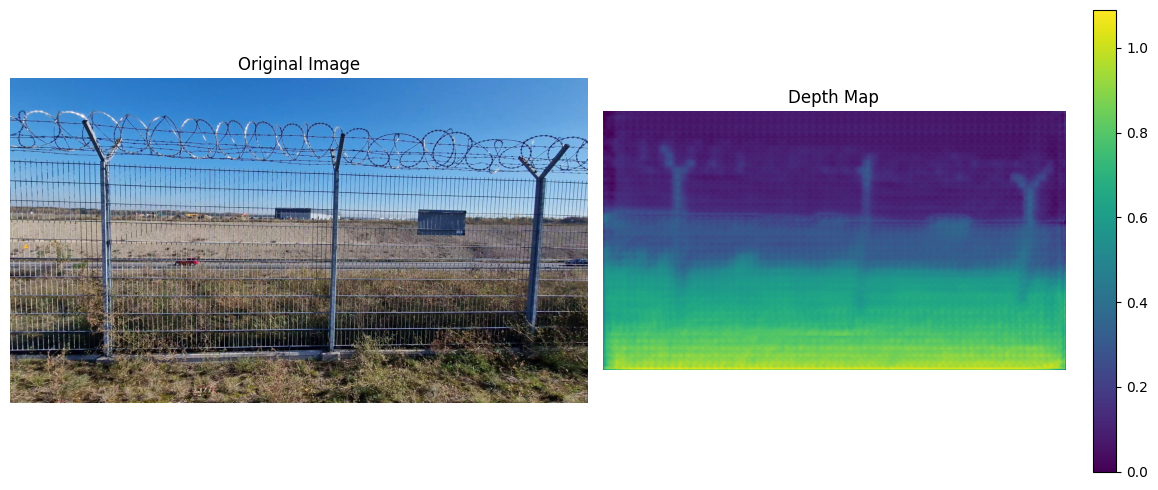

In [6]:
import torch
from transformers import AutoModelForDepthEstimation, AutoImageProcessor
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def predict_depth(model, image_path, processor):
    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")
    
    # Inference
    with torch.no_grad():
        outputs = model(**inputs)
        predicted_depth = outputs.predicted_depth
    
    return predicted_depth.squeeze().numpy()

def visualize_depth(original_image, depth_map):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_image)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title("Depth Map")
    plt.imshow(depth_map, cmap='viridis')
    plt.colorbar()
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Usage example
# Load model and processor
model_path = 'models/depth_model_v2'
# model_path = "LiheYoung/depth-anything-small-hf"
model = AutoModelForDepthEstimation.from_pretrained(model_path)
processor = AutoImageProcessor.from_pretrained(model_path)

# Path to image for inference
# image_path = '20241025_110043.mp4_frame_16.jpg'
image_path = 'depth_dataset/images/20241025_111643-mp4_frame_12_jpg.rf.77116111f3c5a4ed439c3a54db18dffc.jpg'

# Predict depth
depth_map = predict_depth(model, image_path, processor)

# Load original image for visualization
original_image = Image.open(image_path).convert("RGB")

# Visualize results
visualize_depth(original_image, depth_map)

In [ ]:
from transformers import AutoModelForDepthEstimation, AutoImageProcessor
from PIL import Image
import torch

# Wczytaj model i procesor
model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")
processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")

# Przetestuj na obrazach o różnych rozmiarach
image_sizes = [(256, 256), (512, 512), (1024, 1024), (2048, 1024), (1920, 1080), (3840, 2160)]
for size in image_sizes:
    # Stwórz dummy obraz
    dummy_image = Image.new("RGB", size)

    # Przetwórz obraz
    inputs = processor(images=dummy_image, return_tensors="pt")

    # Przekaż przez model
    with torch.no_grad():
        outputs = model(**inputs)

    # Sprawdź rozmiar depthmapy
    depthmap = outputs.predicted_depth
    print(f"Input size: {size}, Depthmap size: {depthmap.shape}, Inputs shape: {inputs['pixel_values'].shape[-2:]}")

AttributeError: 'torch.Size' object has no attribute 'item'